In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
import train

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [3]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t4_data/{key}.pkl')
    return raw[key]

In [4]:
configurations = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_identifier' : "GOLD_FULL",
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t4_models",
    'train_params' : {
        'batch_size': 50000,
        'shuffle': True,
        'num_workers': 3,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 2,
        'pin_memory': True,
    },
}

In [5]:
%%time

train_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=False))
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=True))

train_df = train_df.dropna()
test_df = test_df.dropna()
# train_df = train_df.sample(100000, random_state=42)
# test_df = test_df.sample(10000, random_state=42)

Loading data to cache for: sample_train
Loading data to cache for: sample_test
CPU times: user 865 ms, sys: 705 ms, total: 1.57 s
Wall time: 1.31 s


In [6]:
ref_train, X_train, y_train = get_ref_X_y(train_df)
ref_test, X_test, y_test = get_ref_X_y(test_df)

In [7]:
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_RA_OF_ASC_NODE', 'y_ARG_OF_PERICENTER_REG', 'y_ARG_OF_PERICENTER', 'y_BSTAR', 'y_REV_MA_REG', 'y_MEAN_ANOMALY']
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']
# y_cols = ['y_ARG_OF_PERICENTER_REG']
y_train = y_train[y_cols]
y_test = y_test[y_cols]

# y_train = np.sign(y_train) * np.log(1+np.abs(y_train))
# y_test = np.sign(y_test) * np.log(1+np.abs(y_test))

In [8]:
# model, mean_losses = train.train_model(X_train, y_train, X_test, y_test, configurations, force_train=False)

Loading existing model
AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0.0001
)


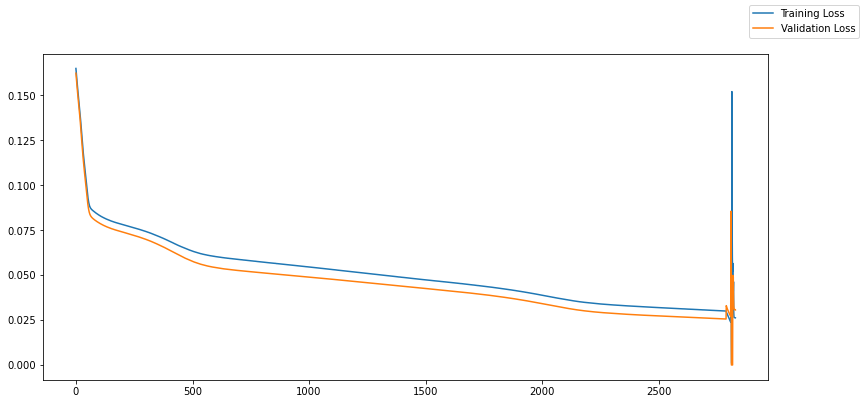

In [9]:
model, loss_func, optimizer, mean_losses, next_epoch = train.load_model_with_config(configurations)
print(optimizer)
tl, vl = zip(*mean_losses)

fig,ax = plt.subplots(figsize=(13,6))
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")
# plt.ylim(0, 0.08)
fig.legend()
plt.show()

In [10]:
mean_losses[2806:]

[(0.024372196053136064, 0.027621566504240035),
 (0.0241089890034024, 0.027424970250576733),
 (0.023865076698302984, 0.027229083273559808),
 (0.0850232929948822, 0.08551508497446775),
 (0.08467176680763562, 0.08514745693653822),
 (0.015691198968472535, 0),
 (0.0008271366375803305, 0),
 (0.15205680710603914, 0),
 (0.08084189498340748, 0),
 (0.05980886313989459, 0),
 (0.052110031411710035, 0),
 (0.055042609572410583, 0.04983111843466759),
 (0.056434200455745064, 0.0391303114593029),
 (0.041107647120952606, 0.048955488950014114),
 (0.046286327143510185, 0.037393372505903244),
 (0.02912286622262743, 0.03273229463025928),
 (0.026638642679077076, 0.031258512157946824),
 (0.026379633885639978, 0.03113801809027791),
 (0.026338473186794532, 0.031030153315514328),
 (0.026308452242977887, 0.030942357890307904),
 (0.02627798537143981, 0.030678265262395144),
 (0.026251146869068164, 0.030596813298761846),
 (0.026222681634158015, 0.030612354576587678)]

In [11]:
trained_model = model
sample_idx = random.sample(list(X_test.index), 10000)

X_sample = X_test.loc[sample_idx]
y_sample = y_test.loc[sample_idx]
# y_train_pred = train.predict(trained_model, X_train, y_train, device="cpu") # get predictions for each train
# y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
y_sample_pred = train.predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe

In [12]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')

# random.seed(342798)
sample = random.sample(list(y_sample_pred_df.index), 10)
# sample = [0,1]

print("Test - Ground Truth (normalized):")
display(y_sample)
print("Test - Prediction (normalized):")
display(y_sample_pred_df)
# print("Ground Truth Diffs from X_:")
# display(y_sample - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)
# print("Pred Diffs from X_:")
# display(y_sample_pred_df - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)


    Test set MAE (L1) loss: 0.06388751227197358
    Test set MSE (L2) loss: 0.025900776681759302
Test - Ground Truth (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
62787,0.5490733333,0.0405048,0.3397114869,0.3622844444,0.3557416667,1.0444019475
43006,0.5498927778,0.1338676,0.4412887417,0.4594125000,0.6534550000,0.7593133951
55073,0.5501933333,0.0653916,0.3662724309,0.6208838889,0.8103366667,0.8020575432
38616,0.1612527778,0.0570904,0.4405087486,0.8690208333,0.8795036111,0.4790842778
47099,0.5500205556,0.0713772,0.3593202880,0.8180275000,0.9373205556,0.5562316759
...,...,...,...,...,...,...
8194,0.3690394444,0.1040696,0.3617232411,0.4404605556,0.8402058333,0.4239242191
75686,0.2389566667,0.0996212,0.3742002011,0.5360788889,0.9439305556,0.4783733457
74734,0.4514738889,0.0213048,0.3287308640,0.6440358333,0.9307252778,0.5563209506
69549,0.5490805556,0.0139252,0.3230849394,0.4017019444,0.4468586111,0.7505980586


Test - Prediction (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
62787,0.5557420254,0.0509014092,0.3424033523,0.3889369965,0.3739207089,1.0179746151
43006,0.5434762836,0.1265173852,0.4441134930,0.4501789212,0.4687636793,0.7503784895
55073,0.5446708202,0.0696762055,0.3549147546,0.5893477201,0.6463297009,0.8093949556
38616,0.1489101946,0.0329943188,0.4479612112,0.8481310606,0.7412286401,0.4556030631
47099,0.5407781601,0.0601355582,0.3639070988,0.7914960980,0.8209432364,0.5393294692
...,...,...,...,...,...,...
8194,0.3648488522,0.0845793486,0.3647315204,0.4219166934,0.5232572556,0.4094720483
75686,0.2305947244,0.0859073848,0.3811192513,0.4858638346,0.5851275921,0.4681200981
74734,0.4535467923,0.0134364963,0.3222244978,0.6012794971,0.6827678680,0.5310255289
69549,0.5457559824,0.0106811635,0.3314576149,0.3923186064,0.4007293880,0.7306128144


In [13]:
# Epoch 2790 switch to full training set